# Preprocessing & Image Enhancement


- imports


In [19]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

> This script loads images from a digit dataset, preprocesses them, and splits them into training and testing sets.

1. Reads image files from ten class folders (0–9).
2. Samples exactly 1000 images per class.
3. Converts images to grayscale and resizes them to 28×28 pixels (LANCZOS filter).
4. Normalizes pixel values to [0,1].
5. Flattens each image into a 784-dimensional vector.
6. Shuffles and splits the dataset into 80% training and 20% testing data.


In [20]:

# Parameters
datasetLocation = './dataset'  
num_samples_per_class = 1000
image_size = (28, 28)  

data = []
labels = []

classes = [str(i) for i in range(10)]  

for cls in classes:
    class_dir = os.path.join(datasetLocation, cls)
    all_images = os.listdir(class_dir)
    
    if len(all_images) < num_samples_per_class:
        raise ValueError(f"Not enough images in class {cls}")
    
    sampled_images = random.sample(all_images, num_samples_per_class)
    
    for img_name in sampled_images:
        img_path = os.path.join(class_dir, img_name)
        
        # Open the image file
        with Image.open(img_path) as img:
            # grayscale
            img = img.convert('L')
            
            img = img.resize(image_size, Image.LANCZOS)
            
            img_array = np.array(img, dtype=np.uint8)
            
            # Normalization
            img_array = img_array / 255  
            
            img_array = img_array.flatten()
            
            data.append(img_array)
            labels.append(int(cls))

data = np.array(data)
labels = np.array(labels)

data, labels = shuffle(data, labels, random_state=42)

# (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (8000, 784)
Training labels shape: (8000,)
Testing data shape: (2000, 784)
Testing labels shape: (2000,)


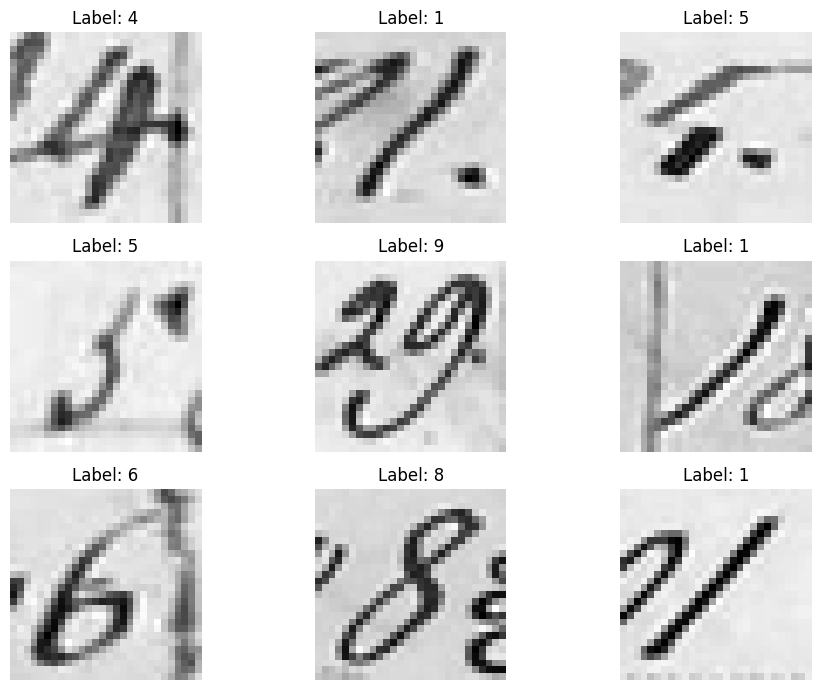

In [21]:
def show_images_grid(images, labels, grid_size=(3, 3), figsize=(10, 7)):
    fig, axes = plt.subplots(*grid_size, figsize=figsize)
    axes = axes.flatten()
    
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

num_images = 9  # Adjust based on grid_size (e.g., 2x3=6)
show_images_grid(X_train[:num_images], y_train[:num_images], grid_size=(3, 3))

# Naive Bayes with Hyperparameter Tuning and Cross-Validation Metrics


**Import Necessary Modules**


In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


1. **Hyperparameter Tuning with GridSearchCV**


In [14]:
# Define the parameter grid to search
param_grid_nb = {
    'var_smoothing': [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
}

# Define scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

# Create the GridSearchCV object
grid_search_nb = GridSearchCV(estimator=GaussianNB(), 
                              param_grid=param_grid_nb, 
                              scoring=scoring_metrics,
                              refit='accuracy',
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                              return_train_score=False,
                              n_jobs=-1)


# Fit the GridSearchCV object to the training data
grid_search_nb.fit(X_train, y_train)

# Get the best estimator
best_nb_model = grid_search_nb.best_estimator_


# Print the best parameters
print("Best parameters found: ", grid_search_nb.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search_nb.best_score_))

Best parameters found:  {'var_smoothing': 1e-12}
Best cross-validation accuracy: 0.5127


2. **Extract Cross-Validation Metrics**

In [15]:
# Get cross-validation results
cv_results = grid_search_nb.cv_results_

# Extract metrics for the best parameter set
mean_test_accuracy = cv_results['mean_test_accuracy']
std_test_accuracy = cv_results['std_test_accuracy']
mean_test_precision = cv_results['mean_test_precision_macro']
std_test_precision = cv_results['std_test_precision_macro']
mean_test_recall = cv_results['mean_test_recall_macro']
std_test_recall = cv_results['std_test_recall_macro']
mean_test_f1 = cv_results['mean_test_f1_macro']
std_test_f1 = cv_results['std_test_f1_macro']


# Find the index of the best parameters
best_index = grid_search_nb.best_index_
print("\nCross-Validation Results (Naive Bayes with Hyperparameter Tuning):")
print(f"Accuracy: {mean_test_accuracy[best_index]:.4f} ± {std_test_accuracy[best_index]:.4f}")
print(f"Precision: {mean_test_precision[best_index]:.4f} ± {std_test_precision[best_index]:.4f}")
print(f"Recall: {mean_test_recall[best_index]:.4f} ± {std_test_recall[best_index]:.4f}")
print(f"F1-score: {mean_test_f1[best_index]:.4f} ± {std_test_f1[best_index]:.4f}")


Cross-Validation Results (Naive Bayes with Hyperparameter Tuning):
Accuracy: 0.5127 ± 0.0140
Precision: 0.5468 ± 0.0183
Recall: 0.5127 ± 0.0140
F1-score: 0.5155 ± 0.0151


3. **Final Evaluation on Test Set**

In [16]:
# Predict on the test set using the best model
y_test_pred_nb_best = best_nb_model.predict(X_test)


# Calculate performance metrics on the test set
test_accuracy_nb_best = accuracy_score(y_test, y_test_pred_nb_best)
test_precision_nb_best = precision_score(y_test, y_test_pred_nb_best, average='macro', zero_division=0)
test_recall_nb_best = recall_score(y_test, y_test_pred_nb_best, average='macro', zero_division=0)
test_f1_nb_best = f1_score(y_test, y_test_pred_nb_best, average='macro', zero_division=0)
test_confusion_matrix_nb_best = confusion_matrix(y_test, y_test_pred_nb_best)


print("\nTest Set Performance (Optimized Naive Bayes):")
print(f"Accuracy: {test_accuracy_nb_best:.4f}")
print(f"Precision: {test_precision_nb_best:.4f}")
print(f"Recall: {test_recall_nb_best:.4f}")
print(f"F1-score: {test_f1_nb_best:.4f}")

print("\nClassification Report (Optimized Naive Bayes):")
print(classification_report(y_test, y_test_pred_nb_best, zero_division=0))



Test Set Performance (Optimized Naive Bayes):
Accuracy: 0.5135
Precision: 0.5455
Recall: 0.5135
F1-score: 0.5179

Classification Report (Optimized Naive Bayes):
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       200
           1       0.32      0.67      0.44       200
           2       0.59      0.41      0.48       200
           3       0.51      0.61      0.56       200
           4       0.51      0.42      0.46       200
           5       0.61      0.41      0.49       200
           6       0.75      0.63      0.68       200
           7       0.52      0.47      0.49       200
           8       0.40      0.41      0.40       200
           9       0.57      0.47      0.51       200

    accuracy                           0.51      2000
   macro avg       0.55      0.51      0.52      2000
weighted avg       0.55      0.51      0.52      2000



4. **Plot Confusion Matrix**

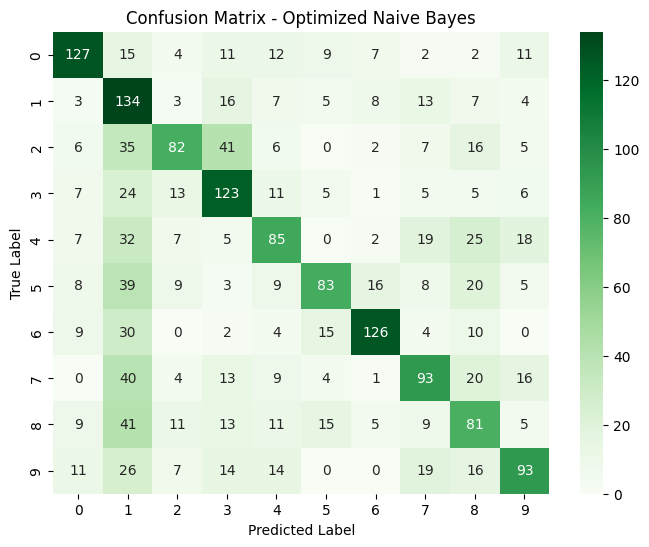

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(test_confusion_matrix_nb_best, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Optimized Naive Bayes")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# MLP


1. **MLP Cross-Validation**

- Use StratifiedKFold to train and evaluate an MLP model on 5 folds of the training set:


In [ ]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score)

# Instantiate the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.001,
                    max_iter=500,
                    random_state=42)

# Prepare lists for cross-validation metrics
acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
    y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
    
    # Train the model on the current fold
    mlp.fit(X_train_cv, y_train_cv)
    
    # Predictions on validation
    y_pred = mlp.predict(X_val_cv)
    
    # Compute metrics
    acc_scores.append(accuracy_score(y_val_cv, y_pred))
    prec_scores.append(precision_score(y_val_cv, y_pred, average='macro', zero_division=0))
    rec_scores.append(recall_score(y_val_cv, y_pred, average='macro', zero_division=0))
    f1_scores.append(f1_score(y_val_cv, y_pred, average='macro', zero_division=0))

print("Cross-Validation Results (MLP):")
print("Accuracy: ", np.mean(acc_scores), "+-", np.std(acc_scores))
print("Precision: ", np.mean(prec_scores), "+-", np.std(prec_scores))
print("Recall: ", np.mean(rec_scores), "+-", np.std(rec_scores))
print("F1: ", np.mean(f1_scores), "+-", np.std(f1_scores))

2. **MLP Final Evaluation on Test Set**

- Train the model on the full training set and evaluate on the test set:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix, classification_report)

# Re-initialize and fit on the entire training set
mlp = MLPClassifier(hidden_layer_sizes=(128, 64),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.001,
                    max_iter=500,
                    random_state=42)

mlp.fit(X_train, y_train)

# Test set predictions
y_test_pred = mlp.predict(X_test)

# Calculate metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_rec = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
test_cm = confusion_matrix(y_test, y_test_pred)

# Print results
print("Test Results (MLP):")
print("Accuracy:", test_acc)
print("Precision:", test_prec)
print("Recall:", test_rec)
print("F1:", test_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Plot confusion matrix
plt.figure()
sns.heatmap(test_cm, annot=True, cmap="Purples", fmt="d")
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

3. **MLP Hyperparameter Tuning (Grid Search)**

- Apply a grid search to find the best hyperparameters:


In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Scale input features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.005, 0.01],
    'max_iter': [2000]
}

mlp_base = MLPClassifier(random_state=42, early_stopping=True)

grid_search = GridSearchCV(estimator=mlp_base,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

mlp_best = MLPClassifier(
    activation=grid_search.best_params_['activation'],
    hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'],
    learning_rate_init=grid_search.best_params_['learning_rate_init'],
    max_iter=grid_search.best_params_['max_iter'],
    solver=grid_search.best_params_['solver'],
    random_state=42
)

mlp_best.fit(X_train_scaled, y_train)
y_test_pred = mlp_best.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy:  {accuracy*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned MLP Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Linear Regression Model


In [22]:
import os
import numpy as np
from PIL import Image
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

- **Implement One-vs-All strategy**


In [23]:
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train)

- **Train a Linear Regression model for each class**


In [24]:
def train_ova_models(X, y_binarized):
    models = []
    for i in range(y_binarized.shape[1]):
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
        model.fit(X, y_binarized[:, i])
        models.append(model)
    return models

ova_models = train_ova_models(X_train, y_train_binarized)

- **Predict probabilities for each class on the test set**


In [25]:
test_predictions = []

for model in ova_models:
    pred = model.predict(X_test)
    test_predictions.append(pred)

In [26]:
test_predictions = np.array(test_predictions)

- **Take the class with the highest predicted value**


In [27]:
y_test_pred_lr = np.argmax(test_predictions, axis=0)
y_test_pred_lr = lb.classes_[y_test_pred_lr]

- **Calculate performance metrics**


In [28]:
Results = {
    "Accuracy": accuracy_score(y_test, y_test_pred_lr),
    "Precision": precision_score(y_test, y_test_pred_lr, average='macro', zero_division=0),
    "Recall": recall_score(y_test, y_test_pred_lr, average='macro', zero_division=0),
    "F1-score": f1_score(y_test, y_test_pred_lr, average='macro', zero_division=0),
    "Confusion Matrix": confusion_matrix(y_test, y_test_pred_lr)
}


In [29]:
print("\n Performance Metrics for Linear Regression (One-vs-All):")
for result, value in Results.items():
    if result != "Confusion Matrix":
        print(f"   {result}: {value:.4f}")
print("==========================================================")


 Performance Metrics for Linear Regression (One-vs-All):
   Accuracy: 0.6860
   Precision: 0.6852
   Recall: 0.6860
   F1-score: 0.6832


- **Display classification report**


In [30]:
print("\nClassification Report (Linear Regression OvA):")
print(classification_report(y_test, y_test_pred_lr, zero_division=0))
print("==============================================================")


Classification Report (Linear Regression OvA):
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       200
           1       0.67      0.77      0.71       200
           2       0.74      0.74      0.74       200
           3       0.72      0.79      0.76       200
           4       0.68      0.70      0.69       200
           5       0.64      0.57      0.60       200
           6       0.70      0.81      0.75       200
           7       0.65      0.64      0.64       200
           8       0.70      0.52      0.60       200
           9       0.64      0.61      0.62       200

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.68      2000
weighted avg       0.69      0.69      0.68      2000



- **Plot confusion matrix**


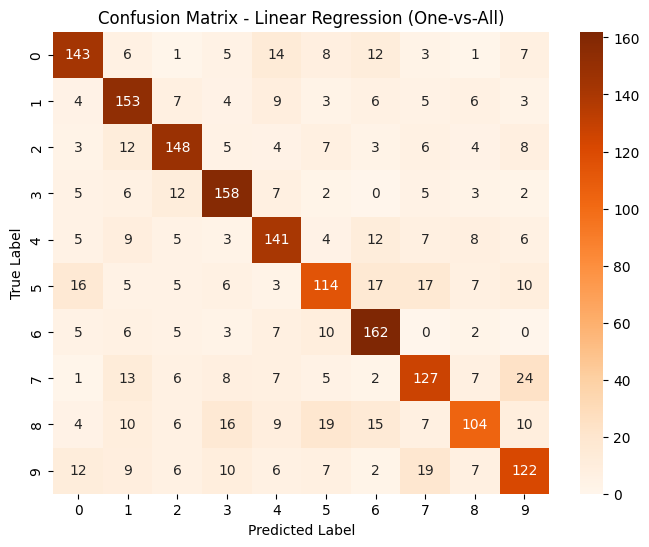

In [31]:
conf_matrix=Results["Confusion Matrix"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title("Confusion Matrix - Linear Regression (One-vs-All)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

- **Discussing failed cases**


In [32]:
failure_cases = np.where(y_test != y_test_pred_lr)[0]
print("\nDiscussion of Failure Cases:")
print(f"Number of misclassified samples: {len(failure_cases)}")


Discussion of Failure Cases:
Number of misclassified samples: 628


In [33]:
print("Examples of misclassified samples:")
for idx in failure_cases[:5]:
    print(f"Sample Index: {idx}, True Label: {y_test[idx]}, Predicted Label: {y_test_pred_lr[idx]}")

Examples of misclassified samples:
Sample Index: 1, True Label: 5, Predicted Label: 6
Sample Index: 5, True Label: 7, Predicted Label: 3
Sample Index: 7, True Label: 8, Predicted Label: 3
Sample Index: 11, True Label: 1, Predicted Label: 3
Sample Index: 17, True Label: 0, Predicted Label: 3



Displaying first 3 misclassified images:


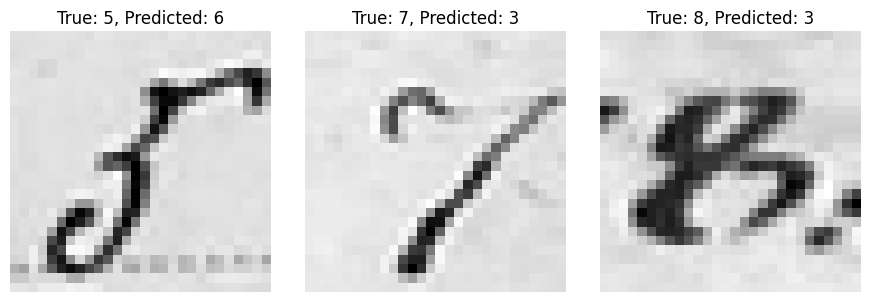

In [34]:
print("\nDisplaying first 3 misclassified images:")
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for i, idx in enumerate(failure_cases[:3]):
    ax = axes[i]
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {y_test[idx]}, Predicted: {y_test_pred_lr[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

- **Setting up Grid Search to modify Hyperparameters**


In [35]:
param_grid = {
            'regressor__alpha': [0.1, 1, 10, 100],
            'regressor__fit_intercept': [True, False],
        }

In [37]:
optimized_ova_models = []
for i in range(y_train_binarized.shape[1]):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge())
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train_binarized[:, i])
    best_model = grid_search.best_estimator_
    optimized_ova_models.append(best_model)
    print(f"Best Parameters for class {i}: {grid_search.best_params_}")

c:\Users\LOQ\Desktop\ml_project\ML_Project\venv\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 0: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


c:\Users\LOQ\Desktop\ml_project\ML_Project\venv\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 1: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


KeyboardInterrupt: 

In [ ]:
optimized_test_predictions = np.array([model.predict(X_test) for model in optimized_ova_models])
y_test_pred_optimized = np.argmax(optimized_test_predictions, axis=0)
y_test_pred_optimized = lb.classes_[y_test_pred_optimized]

In [ ]:
Optimized_Results = {
    "Accuracy": accuracy_score(y_test, y_test_pred_optimized),
    "Precision": precision_score(y_test, y_test_pred_optimized, average='macro', zero_division=0),
    "Recall": recall_score(y_test, y_test_pred_optimized, average='macro', zero_division=0),
    "F1-score": f1_score(y_test, y_test_pred_optimized, average='macro', zero_division=0),
    "Confusion Matrix": confusion_matrix(y_test, y_test_pred_optimized)
}

In [ ]:
print("\nPerformance Metrics for Optimized Ridge Regression:")
for result, value in Optimized_Results.items():
    if result != "Confusion Matrix":
        print(f"   {result}: {value:.4f}")
print("==========================================================")

In [ ]:
print("\nClassification Report (Optimized Ridge Regression):")
print(classification_report(y_test, y_test_pred_optimized, zero_division=0))
print("==============================================================")

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(Optimized_Results["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title("Confusion Matrix - Optimized Ridge Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
